In [1]:
!pip install gdown  # Ensure gdown is installed

In [2]:
import gdown

# Replace FILE_ID with your actual file ID
file_id = "1pUG3KKu7-fLBulAWD5iufk2oN-VHTsdt"
output_file = "Brain_Tumor_Datasets.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1pUG3KKu7-fLBulAWD5iufk2oN-VHTsdt
From (redirected): https://drive.google.com/uc?id=1pUG3KKu7-fLBulAWD5iufk2oN-VHTsdt&confirm=t&uuid=5a161d01-5f34-407c-b298-42ac485739bd
To: /content/Brain_Tumor_Datasets.zip
100%|██████████| 32.9M/32.9M [00:00<00:00, 32.9MB/s]


'Brain_Tumor_Datasets.zip'

In [3]:
import zipfile
z= zipfile.ZipFile('/content/Brain_Tumor_Datasets.zip')
z.extractall()

In [4]:
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
# Set dataset directory paths
train_dir = "Brain_Tumor_Datasets/train"
test_dir = "Brain_Tumor_Datasets/test"


In [6]:
# Initialize the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1]
    validation_split=0.2,  # Set validation split
    rotation_range=20,  # Random rotation between 0 and 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # How to fill in new pixels after transformation
)

# Load training and validation datasets using flow_from_directory
traindata = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',  # For integer labels
    shuffle=True
)

# Load training and validation datasets using flow_from_directory
valdata = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

Found 3598 images belonging to 2 classes.
Found 3598 images belonging to 2 classes.


In [7]:
print(traindata.class_indices)

{'NO': 0, 'YES': 1}


(32, 2)
(32, 224, 224, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


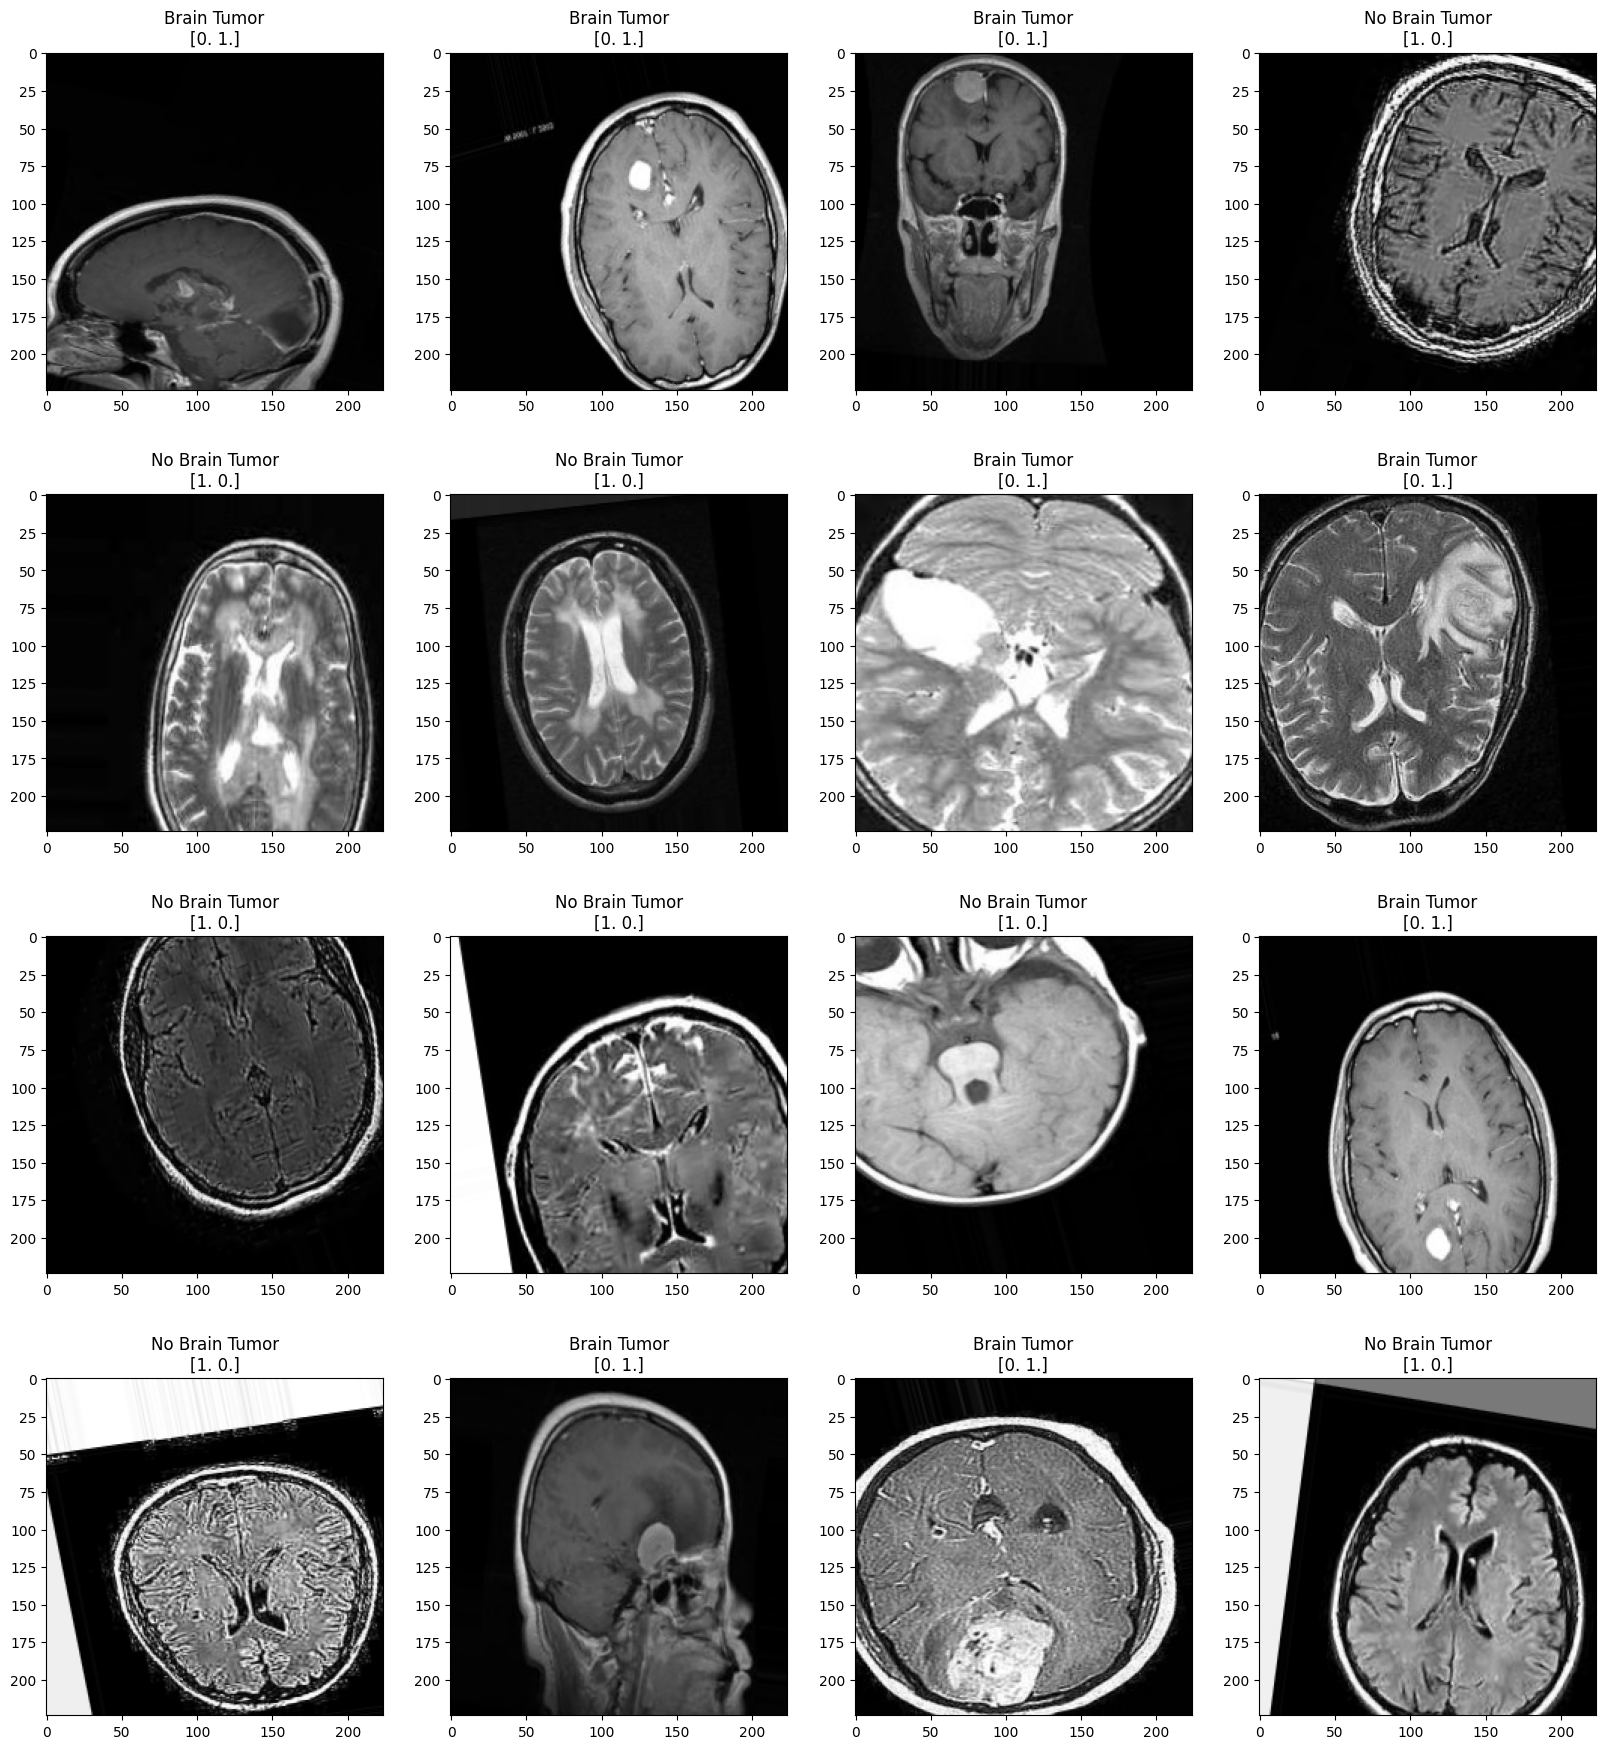

In [8]:
class_name = {0:'No Brain Tumor', 1:'Brain Tumor'}

trainiter = iter(traindata)
images,labels = next(trainiter)

print(labels.shape)
print(images.shape)
print(type(labels))
print(type(images))

fig,axes = plt.subplots(4,4,figsize=(20,22))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(images[i],cmap='gray')
    index = np.argmax(labels[i])
    axes[i].set_title(f'{class_name[index]}\n{labels[i]}')

plt.show()

In [9]:
# 1  2  3        0.9  0.7  1.5
# 4  5  6  ===>  2.2  3    3.8
# 7  8  9        4.5  5.3  5.9

input_size = (224,224,1)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_size))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=0.0008)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,099,906 (53.79 MB)

 Trainable params: 14,095,586 (53.77 MB)

 Non-trainable params: 4,320 (16.88 KB)

In [12]:
modelcheckpoint = ModelCheckpoint('model.keras',
                                  monitor = 'val_accuracy',
                                  save_best_only = True,
                                  mode = 'max',
                                  verbose = 1)

# Learning Rate Scheduler (Cosine Annealing)
def scheduler(epoch, lr):
    return 0.001 * (0.5 ** (epoch // 10))

lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
# Train the model
epochs = 30
history = model.fit(traindata,
                    callbacks = [modelcheckpoint,lr_scheduler],
                    validation_data = valdata,
                    epochs = epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6521 - loss: 0.7695
Epoch 1: val_accuracy improved from -inf to 0.50139, saving model to model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 343ms/step - accuracy: 0.6524 - loss: 0.7682 - val_accuracy: 0.5014 - val_loss: 0.9043 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7595 - loss: 0.4810
Epoch 2: val_accuracy improved from 0.50139 to 0.62146, saving model to model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 280ms/step - accuracy: 0.7596 - loss: 0.4808 - val_accuracy: 0.6215 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7884 - loss: 0.4379
Epoch 3: val_accuracy did not improve from 0.62146
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - accuracy: 0.7885 - loss: 0.4378 - val_accuracy: 0.5623 - val_loss: 0.7402 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8252 - loss: 0.3786


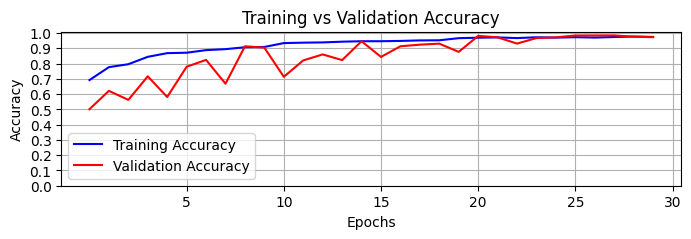

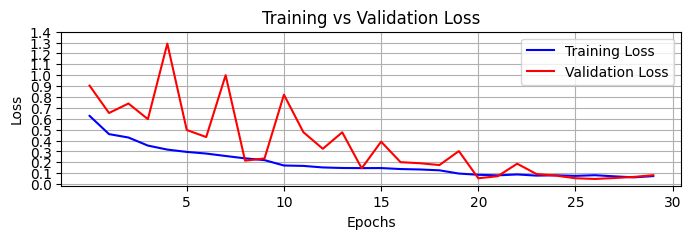

In [37]:
plt.figure(figsize=(8, 2))
plt.plot(history.history['accuracy'], label="Training Accuracy", color='b')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='r')
plt.xticks(np.arange(5, epochs + 1, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 2))
plt.plot(history.history['loss'], label="Training Loss", color='b')
plt.plot(history.history['val_loss'], label="Validation Loss", color='r')
plt.xticks(np.arange(5, epochs + 1, 5))
plt.yticks(np.arange(0, 1.5, 0.1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.4338499 0.5661501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[0.6494097 0.3505903]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[0.9906221  0.00937782]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[9.9986827e-01 1.3167821e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[5.3080823e-04 9.9946922e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.7054131 0.2945869]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[2.5305872e-05 9.9997473e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.39915526 0.60084474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[9.997148e-01 2.851991e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.25714445 0.7428555 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[0.9692889 0.0307111]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[9.9927574e-01 7.2423264e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.99544525 0.00455479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[4.936749e-06 9.999951e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.99544525 0.00455479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0.001894

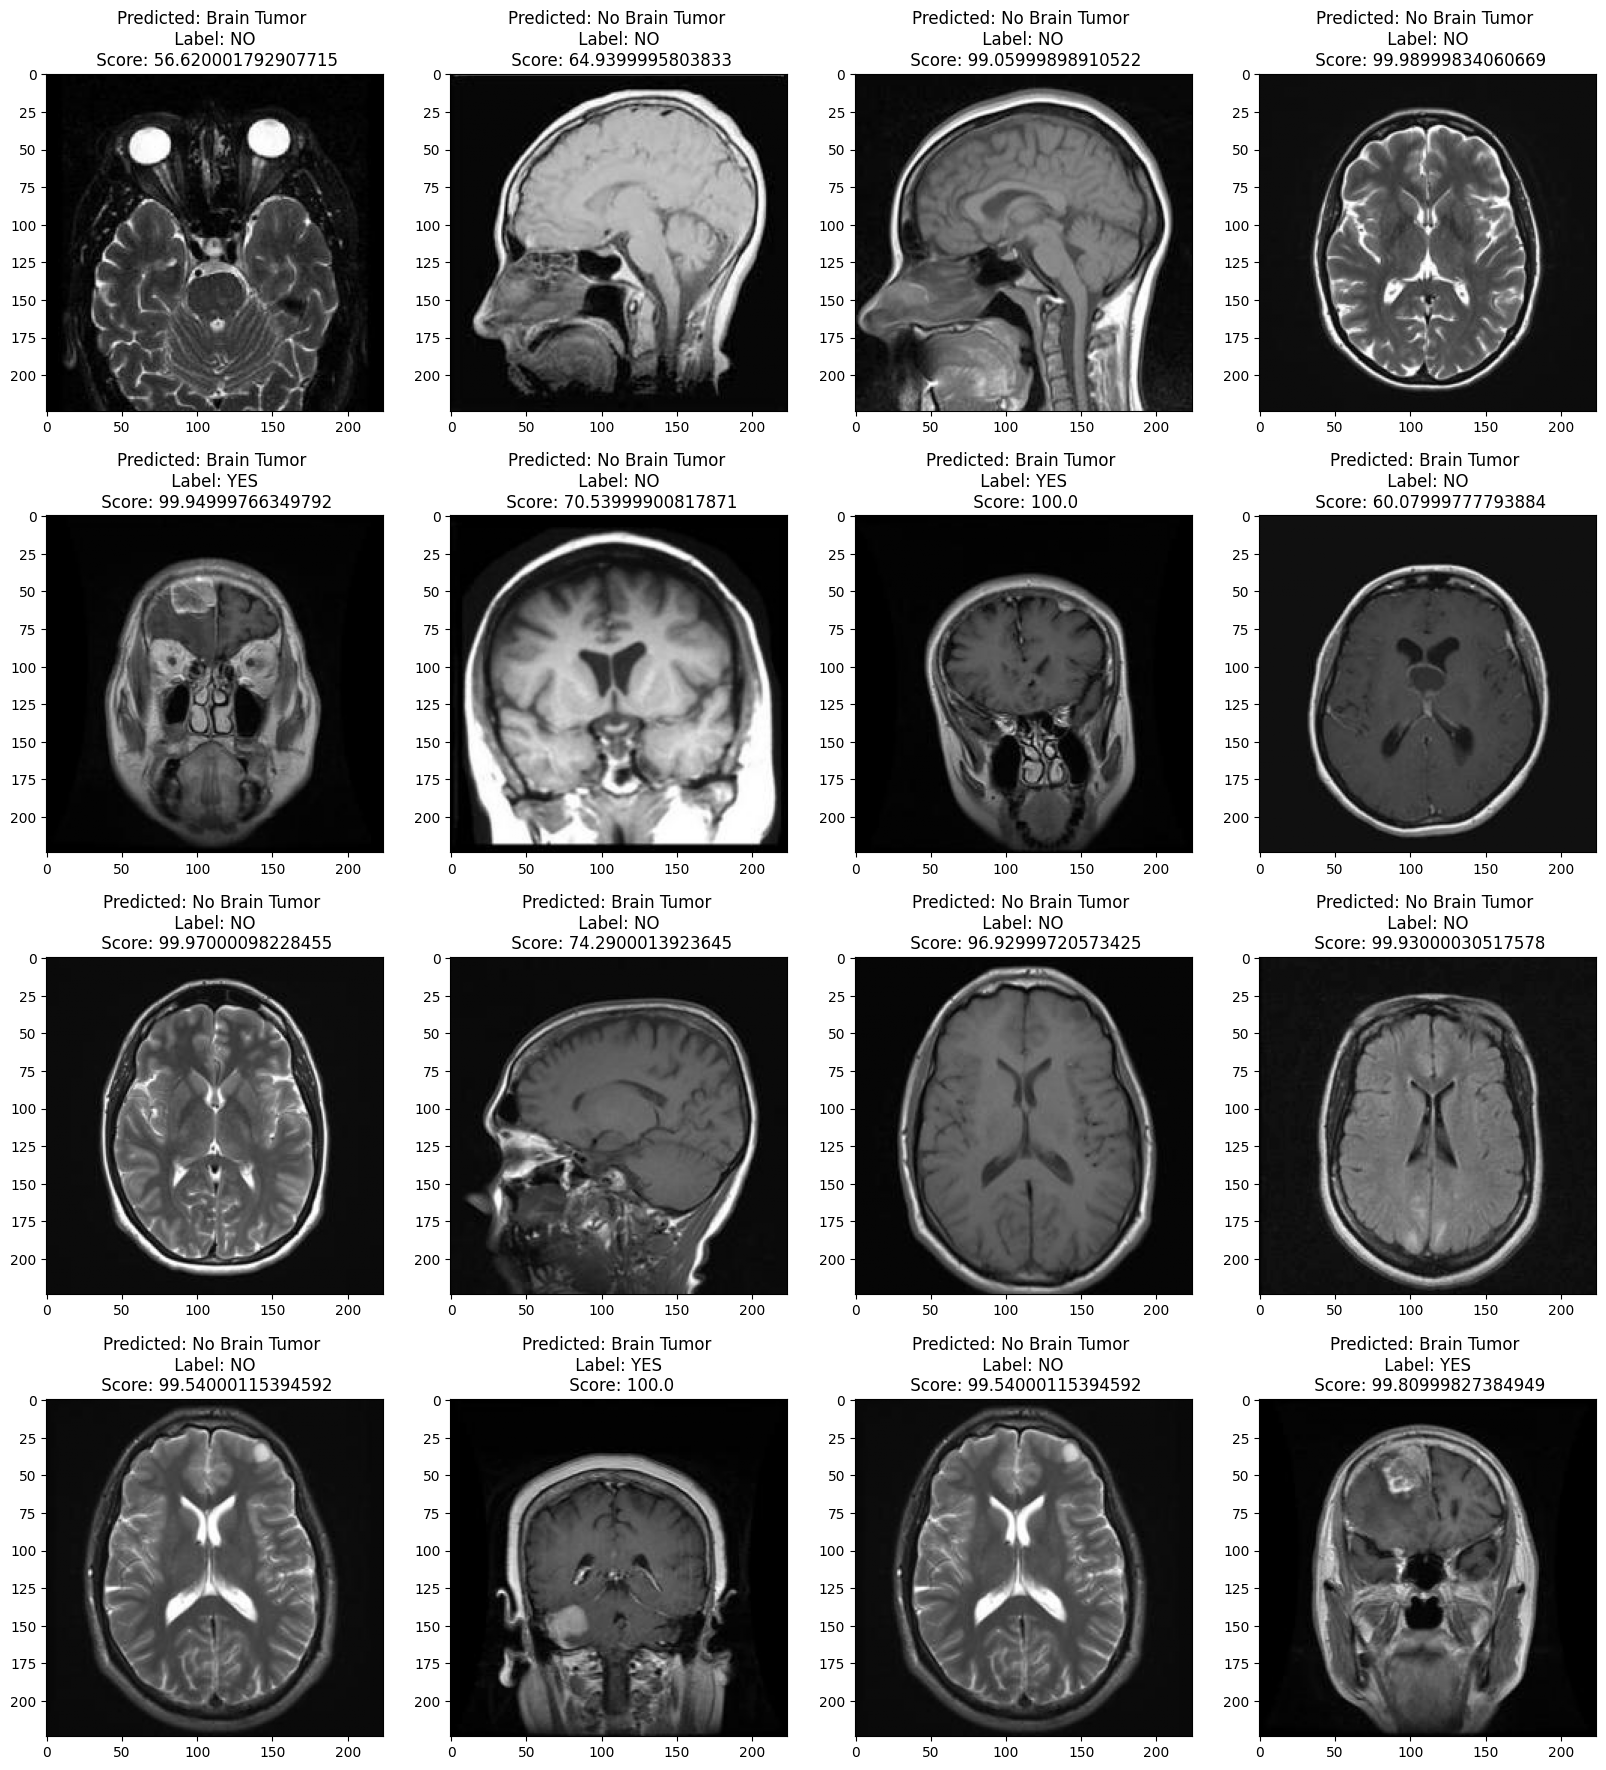

In [35]:
from PIL import Image, ImageOps
import os
import random

model = keras.models.load_model("model.keras")

fig, axes = plt.subplots(4,4, figsize=(20,22))
axes = axes.ravel()

class_name = {0:'No Brain Tumor', 1:'Brain Tumor'}

test_dir = 'Brain_Tumor_Datasets/test'
test_dir_folders = os.listdir(test_dir)


for i in range(16):
  test_dir_folder = random.choice(test_dir_folders)
  test_dir_files = os.listdir(os.path.join(test_dir,test_dir_folder))
  img_path = os.path.join(test_dir,test_dir_folder,random.choice(test_dir_files))

  img = Image.open(img_path)
  img = ImageOps.grayscale(img)
  img_pred = np.array(img)
  img_pred = np.expand_dims(img_pred, axis=0)
  img_pred = img_pred / 255.0

  pred = model.predict(img_pred)[0]

  pred_index = np.argmax(pred, axis=-1)
  score = np.round(pred[pred_index], 4) * 100
  actual_index = np.argmax(labels[i], axis=-1)
  print(pred)

  axes[i].imshow(img,cmap='gray')
  axes[i].set_title(f'Predicted: {class_name[pred_index]} \n Label: {test_dir_folder} \n Score: {score}')

plt.show()